In [29]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:1")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(1))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    

There are 4 GPU(s) available.
We will use the GPU: TITAN X (Pascal)


In [30]:
# !pip install transformers

In [31]:
import pandas as pd

print('Parsing the dataset.tsv file ....')
# comments = pd.read_csv('./data/attack_annotated_comments.tsv', sep = '\t', index_col = 0)
train = pd.read_csv('./data/balanced_data/train.tsv', sep = '\t')
test = pd.read_csv('./data/balanced_data/test.tsv', sep = '\t')

print('     DONE.')

Parsing the dataset.tsv file ....
     DONE.


In [32]:
# Display the first five rows of the table
for i in range(len(train)):
    train.iloc[i].len = len(train.iloc[i].raw_text.split())

train.head()

,story_id,raw_text,label,len
0,6772845,"kiev, january 21 (ria novosti) - former ukrain...",1,160
1,35455458,the ukrainian government has called for local ...,0,56
2,38817309,investigators probing the shooting down of mal...,0,343
3,7765503,"kharkov, april 21 (ria novosti) - russia and u...",1,227
4,34816385,"moscow, june 27 (ria novosti) - osce monitors ...",1,250


In [33]:
def get_split(text1):
    split_size = 200
    overlap_size = 50
    v1 = split_size - overlap_size
    l_total = []
    l_parcial = []
    if len(text1.split())//v1 >0:
        n = len(text1.split())//v1
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:split_size]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*v1:w*v1 + split_size]
            l_total.append(" ".join(l_parcial))
    return l_total

In [34]:
train['text_split'] = train['raw_text'].apply(get_split)
train.head()

,story_id,raw_text,label,len,text_split
0,6772845,"kiev, january 21 (ria novosti) - former ukrain...",1,160,"[kiev, january 21 (ria novosti) - former ukrai..."
1,35455458,the ukrainian government has called for local ...,0,56,[the ukrainian government has called for local...
2,38817309,investigators probing the shooting down of mal...,0,343,[investigators probing the shooting down of ma...
3,7765503,"kharkov, april 21 (ria novosti) - russia and u...",1,227,"[kharkov, april 21 (ria novosti) - russia and ..."
4,34816385,"moscow, june 27 (ria novosti) - osce monitors ...",1,250,"[moscow, june 27 (ria novosti) - osce monitors..."


In [35]:
# create a row split version of dataset 

from tqdm import tqdm_notebook as tqdm
tmp = []

for i in tqdm(range(len(train))):
    for j in range(len(train.iloc[i].text_split)):
        chunk_num = str(train.iloc[i]['story_id']) + '_' + str(j)
        tmp.append(
        {'story_id': train.iloc[i]['story_id'],
            'chunk_num': chunk_num,
            'raw_text': train.iloc[i]['raw_text'],
            'text_chunk': train.iloc[i]['text_split'][j],
            'label': train.iloc[i].label}
        )

train_split_v = pd.DataFrame(tmp) 
# train.head()
print('length of train_split_v is:', len(train_split_v))
train_split_v.head()



length of train_split_v is: 19057


,story_id,chunk_num,raw_text,text_chunk,label
0,6772845,6772845_0,"kiev, january 21 (ria novosti) - former ukrain...","kiev, january 21 (ria novosti) - former ukrain...",1
1,35455458,35455458_0,the ukrainian government has called for local ...,the ukrainian government has called for local ...,0
2,38817309,38817309_0,investigators probing the shooting down of mal...,investigators probing the shooting down of mal...,0
3,38817309,38817309_1,investigators probing the shooting down of mal...,at ukraine's military. members of the joint in...,0
4,7765503,7765503_0,"kharkov, april 21 (ria novosti) - russia and u...","kharkov, april 21 (ria novosti) - russia and u...",1


In [36]:
print('length of train_split_v is:', len(train_split_v))

length of train_split_v is: 19057


In [37]:
# import textwrap
# import random 

# # wrap text to 80 characters.

# wrapper = textwrap.TextWrapper(width = 100)

# # filter to just "attack" comments.

# examples = train.query('label')['raw_text']

# # Randomly choose some examples

# for i in range(10):
#     j = random.choice(examples.index)
    
#     print('')
#     print(wrapper.fill(examples[j]))
#     print('')

In [38]:
from transformers import BertTokenizer

# load the BERT tokenizer, 
print('loading BERT tokenizer....')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
print('    DONE.')

loading BERT tokenizer....
    DONE.


In [39]:
# # Retrieve the text from the first comment.
# text = train.iloc[10].raw_text

# tokens = tokenizer.tokenize(text)

# # Print the original text
# print('comment 0 (not an attack) contains {:,} wordpiece tokens.'.format(len(tokens)))
# print('\nOriginal comment text:\n')
# print(wrapper.fill(text))


# # print out the list of tokens
# print('**** First 512 tokens:*****\n')
# print(wrapper.fill(str(' '.join(tokens[0:512]))))

# print('')

# print('\n****** Remaining {:,} tokens: *****\n'.format(len(tokens) - 512))
# print(wrapper.fill(str(' '.join(tokens[512:]))))

In [40]:
# # First truncate the text to remove the last 79 tokens (which begin with the words "are made in"). 
# last_char = text.find('are made in')

# # Truncate the text to only what fits in the 512 tokens.
# text = text[0:last_char]

# # Estimate the number of words in the comment by spliting it on whitespace.
# # first remove all double spaces.
# text = text.replace('  ', ' ')
# num_words = len(text.split(' '))
# print('Comment contains ~{:,} words.'.format(num_words))

# # Estimate the number of sentences by counting up the periods.
# num_sens = text.count('. ')
# print('Comment contains ~{:,} sentences.'.format(num_sens))

In [41]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

# Tokenize all the sentences and map the tokens to their word IDs.

input_ids = []

# Record the length of each sequence (after truncating to 512).

lengths = []

print('Tokenizing comments.....')

# For every sentence....
for text in tqdm(train_split_v.text_chunk):
    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print(' Read {:,} texts.'.format(len(input_ids)))
        
    # endoce will: 
    # (1) Tokenize the sentence
    # (2) Prepend the "[CLS]" token to the start.
    # (3) Append the "[SEP]" token to the end.
    # (4) Map tokens to their IDs. 
    encoded_text = tokenizer.encode(
        text,                          #sentence to encode.
        add_special_tokens = True,   # Add '[CLS]' and '[SEP]'
#             max_length = 512,            # Truncate all the sentences.
#             return_tensors = 'pt'        # Return pytorch tensors.
    )
    # Add the encoded sentence to the list
    input_ids.append(encoded_text)
    
    # Record the truncated length.
    lengths.append(len(encoded_text))
    
print('DONE')
print('{:>10,} comments'.format(len(input_ids)))

print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

Tokenizing comments.....


 Read 0 texts.

DONE
    19,057 comments
   Min length: 18 tokens
   Max length: 395 tokens
Median length: 251.0 tokens


In [42]:
# ALso retreive the labels as a list

# Get the labels from dataframe, and convert from booleans to ints.

labels = train_split_v.label.to_numpy().astype(int)
print('{:>7,} label as 1 '.format(np.sum(labels)))
print('{:>7,} labels as 0'.format(len(labels)-np.sum(labels)))

  7,380 label as 1 
 11,677 labels as 0


In [43]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# sns.set(style='darkgrid')

# # Increase the plot size and font size.
# sns.set(font_scale=1.5)
# plt.rcParams['figure.figsize'] = (10,5)

# # Truncate any comment lengths greater tahn 512.
# lengths = [min(l, 512) for l in lengths]

# # Plot the distribution of comment lengths.
# sns.distplot(lengths, kde=False, rug=False)
# plt.title('Comment lengths')
# plt.xlabel('Comment length')
# plt.ylabel ('# of comments')

In [44]:
# # count the number of sentences that had to be truncated to 512 tokens. 
# num_truncated = lengths.count(512)

# # compare this to the total number of training sentences.
# num_sentences = len(lengths)
# prcnt = float(num_truncated)/ float(num_sentences)
# print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than 512 tokens.'.format(num_truncated, num_sentences, prcnt))

In [45]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
MAX_LEN = 512

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 512 values...

Padding token: "[PAD]", ID: 0

Done.


In [46]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [47]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [48]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [49]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [50]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
if torch.cuda.is_available():
        model.cuda()
        model = torch.nn.DataParallel(model)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [51]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizable_params = []
for name, p in model.named_parameters():
    if p.requires_grad:
#         print(p.name, p.shape)
        print(name, p.shape)
        if name == 'classifier.bias' or name == 'classifier.weight':
            optimizable_params.append(p)
# for p in model.parameters():
#     if p.requires_grad:
# #         print(p.name, p.shape)
# #         print(name, p.shape)
#         if p.name == 'classifer.bias' or p.name == 'classifier.weight':
#             optimizable_params.append(p)
print("----")            
# print(optimizable_params)
# for p in optimizable_params:
#     print(p.shape)
optimizer = AdamW(model.parameters(),#optimizable_params,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

module.bert.embeddings.word_embeddings.weight torch.Size([30522, 768])
module.bert.embeddings.position_embeddings.weight torch.Size([512, 768])
module.bert.embeddings.token_type_embeddings.weight torch.Size([2, 768])
module.bert.embeddings.LayerNorm.weight torch.Size([768])
module.bert.embeddings.LayerNorm.bias torch.Size([768])
module.bert.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
module.bert.encoder.layer.0.attention.self.query.bias torch.Size([768])
module.bert.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
module.bert.encoder.layer.0.attention.self.key.bias torch.Size([768])
module.bert.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
module.bert.encoder.layer.0.attention.self.value.bias torch.Size([768])
module.bert.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
module.bert.encoder.layer.0.attention.output.dense.bias torch.Size([768])
module.bert.encoder.layer.0.attention.output.LayerNorm.weight tor

In [52]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 20

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [53]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [54]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [55]:
def model_save():
    import os

    # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

    output_dir = './model_save/'

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Saving model to %s" % output_dir)

    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    # Good practice: save your training arguments together with the trained model
    # torch.save(args, os.path.join(output_dir, 'training_args.bin'))
    return

In [59]:
torch.cuda.empty()

AttributeError: module 'torch.cuda' has no attribute 'empty'

In [60]:
import random
import os
from torch.utils.tensorboard import SummaryWriter

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
log_dir  = './tensorboard_log/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir=log_dir)


# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = []
    max_accuracy = 0.65
    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 200 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0].mean()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.

        total_loss.append(loss.data.cpu().numpy())
        # print(loss)
        # if step % 10 == 0:
        #     writer.add_scalar('loss', loss, step)

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = sum(total_loss) / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation. 
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        
        if tmp_eval_accuracy > max_accuracy: 
            max_accuracy = tmp_eval_accuracy
            model_save()
        # Track the number of batches
        nb_eval_steps += 1
    
    
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 20 ========
Training...


KeyboardInterrupt: 

In [ ]:
# print(loss.data.cpu().numpy())
# !pwd

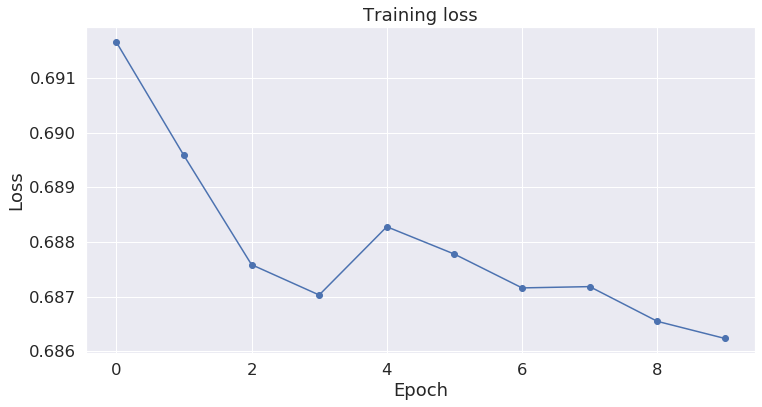

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [31]:
# Apply split function on the test data
test['text_split'] = test['raw_text'].apply(get_split)
test.head()

# create a row split version of dataset 

from tqdm import tqdm_notebook as tqdm
tmp = []

for i in tqdm(range(len(test))):
    for j in range(len(test.iloc[i].text_split)):
        chunk_num = str(test.iloc[i]['story_id']) + '_' + str(j)
        tmp.append(
        {'story_id': test.iloc[i]['story_id'],
            'chunk_num': chunk_num,
            'raw_text': test.iloc[i]['raw_text'],
            'text_chunk': test.iloc[i]['text_split'][j],
            'label': test.iloc[i].label}
        )

test_split_v = pd.DataFrame(tmp) 
# train.head()
print('length of test_split_v is:', len(train_split_v))
test_split_v.head()

/home/maryam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



length of test_split_v is: 11040


,story_id,chunk_num,raw_text,text_chunk,label
0,35358787,35358787_0,"brussels, september 3 (ria novosti) the europ...","brussels, september 3 (ria novosti) the europe...",1
1,13312382,13312382_0,german chancellor angela merkel said monday sh...,german chancellor angela merkel said monday sh...,0
2,35312144,35312144_0,european union foreign ministers on friday cle...,european union foreign ministers on friday cle...,0
3,35312144,35312144_1,european union foreign ministers on friday cle...,had to be sent a clear message that its incurs...,0
4,34817284,34817284_0,"kiev, june 24 (ria novosti) ukrainian preside...","kiev, june 24 (ria novosti) ukrainian presiden...",1


In [32]:
# Performance On Test Set
# Data preparation



# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []


# For every sentence...
for text in test_split_v.text_chunk:
    
    # Report progress. 
    if ((len(input_ids) % 20000) == 0):
        print('    Read {:,} comments.'.format(len(input_ids)))
        
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,       # Truncate all sentences 
                   )
    # Add the method sentence to the list
    test_input_ids.append(encoded_sent)
    
print('DONE.')
print('')
print('{:>20,} test comments.'.format(len(test_input_ids)))


# Also retrieve the labels as a list:
# Get the labels from the Dataframe and convert from booleans to ints. 

test_labels = test_split_v['label'].to_numpy().astype(int)

print('{:>20,} labeled as 1'.format(np.sum(test_labels)))
print('{:>20,} labeled as 0'.format(len(test_labels) - np.sum(test_labels)))

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask) 

# Convert to tensors.
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 16  

# Create the DataLoader.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

DONE.

               2,702 test comments.
               1,186 labeled as 1
               1,516 labeled as 0


In [33]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0: 
        # calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress
        print('    Batch {:>5,}  of  {:>5,},      Elapsed: {:}.'.format(step, len(test_labels), elapsed))
        
        
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,702 test sentences...
    Batch   100  of  2,702,      Elapsed: 0:00:16.
    DONE.


In [34]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [35]:
predictions[20:40]

array([[ 0.16747084, -0.09904484],
       [ 0.1662383 , -0.09477215],
       [ 0.16399503, -0.09905042],
       [ 0.16810508, -0.09691988],
       [ 0.16665009, -0.09503195],
       [ 0.16630077, -0.09839007],
       [ 0.16835368, -0.09515082],
       [ 0.16914505, -0.09748755],
       [ 0.1666932 , -0.09336632],
       [ 0.16807283, -0.09462682],
       [ 0.16497596, -0.09761261],
       [ 0.16601484, -0.09732819],
       [ 0.16813472, -0.09486486],
       [ 0.1663592 , -0.09482013],
       [ 0.16552177, -0.09467977],
       [ 0.1653005 , -0.09803161],
       [ 0.16651098, -0.09912128],
       [ 0.16744445, -0.09720971],
       [ 0.16649315, -0.09775088],
       [ 0.1671198 , -0.09889032]], dtype=float32)

In [36]:
true_labels[20:40]

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1])

In [48]:
p1 = predictions[:,1]-predictions[:,0]
pred_label = []
for i in p1:
    if i>0:
        pred_label.append(1)
    elif i<=0:
        pred_label.append(0)    


accuracy = np.sum(pred_label == true_labels) / len(true_labels)
print(accuracy)

0.5610658771280533


In [49]:
# Our performance metric for the test set.
from sklearn.metrics import roc_auc_score

# Use the model output for label 1 as our prediction.
p1 = predictions[:,1]-predictions[:,0]

# Calculate the ROC AUC
auc = roc_auc_score(true_labels, p1)

print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.460


In [38]:
!ls -l --block-size=K ./model_save/

total 427964K
-rw-rw-r-- 1 maryam maryam      2K Oct  9 17:40 config.json
-rw-rw-r-- 1 maryam maryam 427721K Oct  9 17:40 pytorch_model.bin
-rw-rw-r-- 1 maryam maryam      1K Oct  9 17:40 special_tokens_map.json
-rw-rw-r-- 1 maryam maryam      1K Oct  9 17:40 tokenizer_config.json
-rw-rw-r-- 1 maryam maryam    227K Oct  9 17:40 vocab.txt


In [39]:
# # Load a trained model and vocabulary that you have fine-tuned
# model = model_class.from_pretrained(output_dir)
# tokenizer = tokenizer_class.from_pretrained(output_dir)

# # Copy the model to the GPU.
# model.to(device)